# Predicting Heart Disease 

## Introduction

Heart disease is currently the leading cause of death from a non-transmissible source with 8.9 million people dying from it annually (Filate et al. 2003; Health Agency of Canada 2018). This is mainly due to a growing aging population making it so a larger portion of people are more prone to cardiovascular diseases (Health Agency of Canada 2018; Statista 2021). However, the disease takes years to develop and is very easily preventable by monitoring or reducing risk factors through various lifestyle changes such as eating a healthy diet, increasing physical activity, and limiting smoking and alcohol consumption (Statista 2021; Government of Canada, 2017). Therefore, early detection of risk factors can help prevent heart disease from developing, or can help prevent the progression of the disease. 

Hence, our research question is:
How can age, blood pressure, cholesterol, heart rate, and number of major blood vessels predict heart disease?

For this analysis we will be using the modified Cleveland dataset from the Heart Disease Data Set from the UCI Machine Learning Repository. The dataset consists of 15 different attributes as follows:

1) age: Age of person in years

2) sex: (1 = male, 0 = female)

3) cp_type: The types of chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)

4) rest_bp: Resting blood pressure (mm Hg on admission to the hospital)

5) chol: serum cholesterol in mg/dl

6) fbs: Fasting blood sugar (if > 120 mg/dl, 1 = true; 0 = false)

7) restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes’ criteria)

8) max_hr: Maximum heart rate achieved

9) eia: Exercise induced angina (1 = yes; 0 = no)

10) op: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot)

11) slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)

12) num_bv: The number of major vessels (0–3)

13) thal: A blood disorder called thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)

14) class: With or without heart disease (buff = healthy, sick = heart disease)

15) health: Heart disease (0 = no, 1, 2, 3, 4 = yes)

To create our model, we will be analyzing the numerical attributes; 1) age, 4) resting blood pressure, 5) cholesterol, 8) max heart rate, and 12) number of major blood vessels to explore any relationship between these variables and heart disease. Then, we will select which predictors are the most significant and design our model around those. 


## Exploratory Analysis

In [52]:
#Downloading the necessary packages.
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
library(digest)
library(infer)
library(cowplot)

In [53]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod"
download.file (url,"cleve.mod" )
colnames <-c("age","sex","cp_type","rest_bp", "chol", 
             "fbs","restecg","max_hr","eia", 
             "op","slope","num_bv","thal","class","health") #Adding column names
clev_data <-read_delim("cleve.mod", skip=20, delim="   ", col_names = colnames) %>%
    mutate(class = as_factor(class)) %>% #Wrangling data and selecting columns to be used in prediction
    mutate(max_hr = as.numeric(max_hr))%>%
    mutate(num_bv = as.numeric(num_bv))%>%
    mutate(rest_bp = as.numeric(rest_bp)) %>%
    select(age, rest_bp, chol, max_hr, num_bv, class) %>%
    filter(class == "buff" | class == "sick")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_character(),
  cp_type = col_character(),
  rest_bp = col_character(),
  chol = col_double(),
  fbs = col_character(),
  restecg = col_character(),
  max_hr = col_character(),
  eia = col_character(),
  op = col_character(),
  slope = col_character(),
  num_bv = col_character(),
  thal = col_character(),
  class = col_character(),
  health = col_character()
)

Warning message:
“Problem with `mutate()` input `num_bv`.
ℹ NAs introduced by coercion
ℹ Input `num_bv` is `as.numeric(num_bv)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [54]:
#Splitting the data into a training and a testing set.
#75% of the data will be randomly taken as training data.
clev_split <- initial_split(clev_data, prop = 0.75, strata = class)  
clev_train <- training(clev_split)   
clev_test <- testing(clev_split)
head(clev_train)

age,rest_bp,chol,max_hr,num_bv,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0,buff
67,160,286,108,3,sick
67,120,229,129,2,sick
41,130,204,172,0,buff
57,120,354,163,0,buff
63,130,254,147,1,sick


##### Table 1: Top 6 Rows of Cleveland Training Data

In [55]:
#Visualizing the summary of the predictor variables.
print(summary(clev_train))


      age           rest_bp           chol           max_hr     
 Min.   :29.00   Min.   : 94.0   Min.   :131.0   Min.   : 71.0  
 1st Qu.:48.00   1st Qu.:120.0   1st Qu.:211.0   1st Qu.:136.0  
 Median :56.00   Median :130.0   Median :240.5   Median :154.0  
 Mean   :54.63   Mean   :132.2   Mean   :245.9   Mean   :150.0  
 3rd Qu.:61.00   3rd Qu.:140.0   3rd Qu.:273.0   3rd Qu.:165.8  
 Max.   :77.00   Max.   :192.0   Max.   :417.0   Max.   :202.0  
                                                                
     num_bv         class    
 Min.   :0.0000   buff :123  
 1st Qu.:0.0000   sick :103  
 Median :0.0000    buff:  0  
 Mean   :0.6471    sick:  0  
 3rd Qu.:1.0000              
 Max.   :3.0000              
 NA's   :5                   


##### Table 2: Summary Statistics of Training Data

In [56]:
#Finding the number of rows in the training data
print(nrow(clev_train))

[1] 226


In [57]:
#Cleaining the data by removing the missing values in num_bv.
clev_train_clean <- clev_train %>%
    filter(num_bv != "NA")
clev_test_clean <- clev_test %>%
    filter(num_bv != "NA")

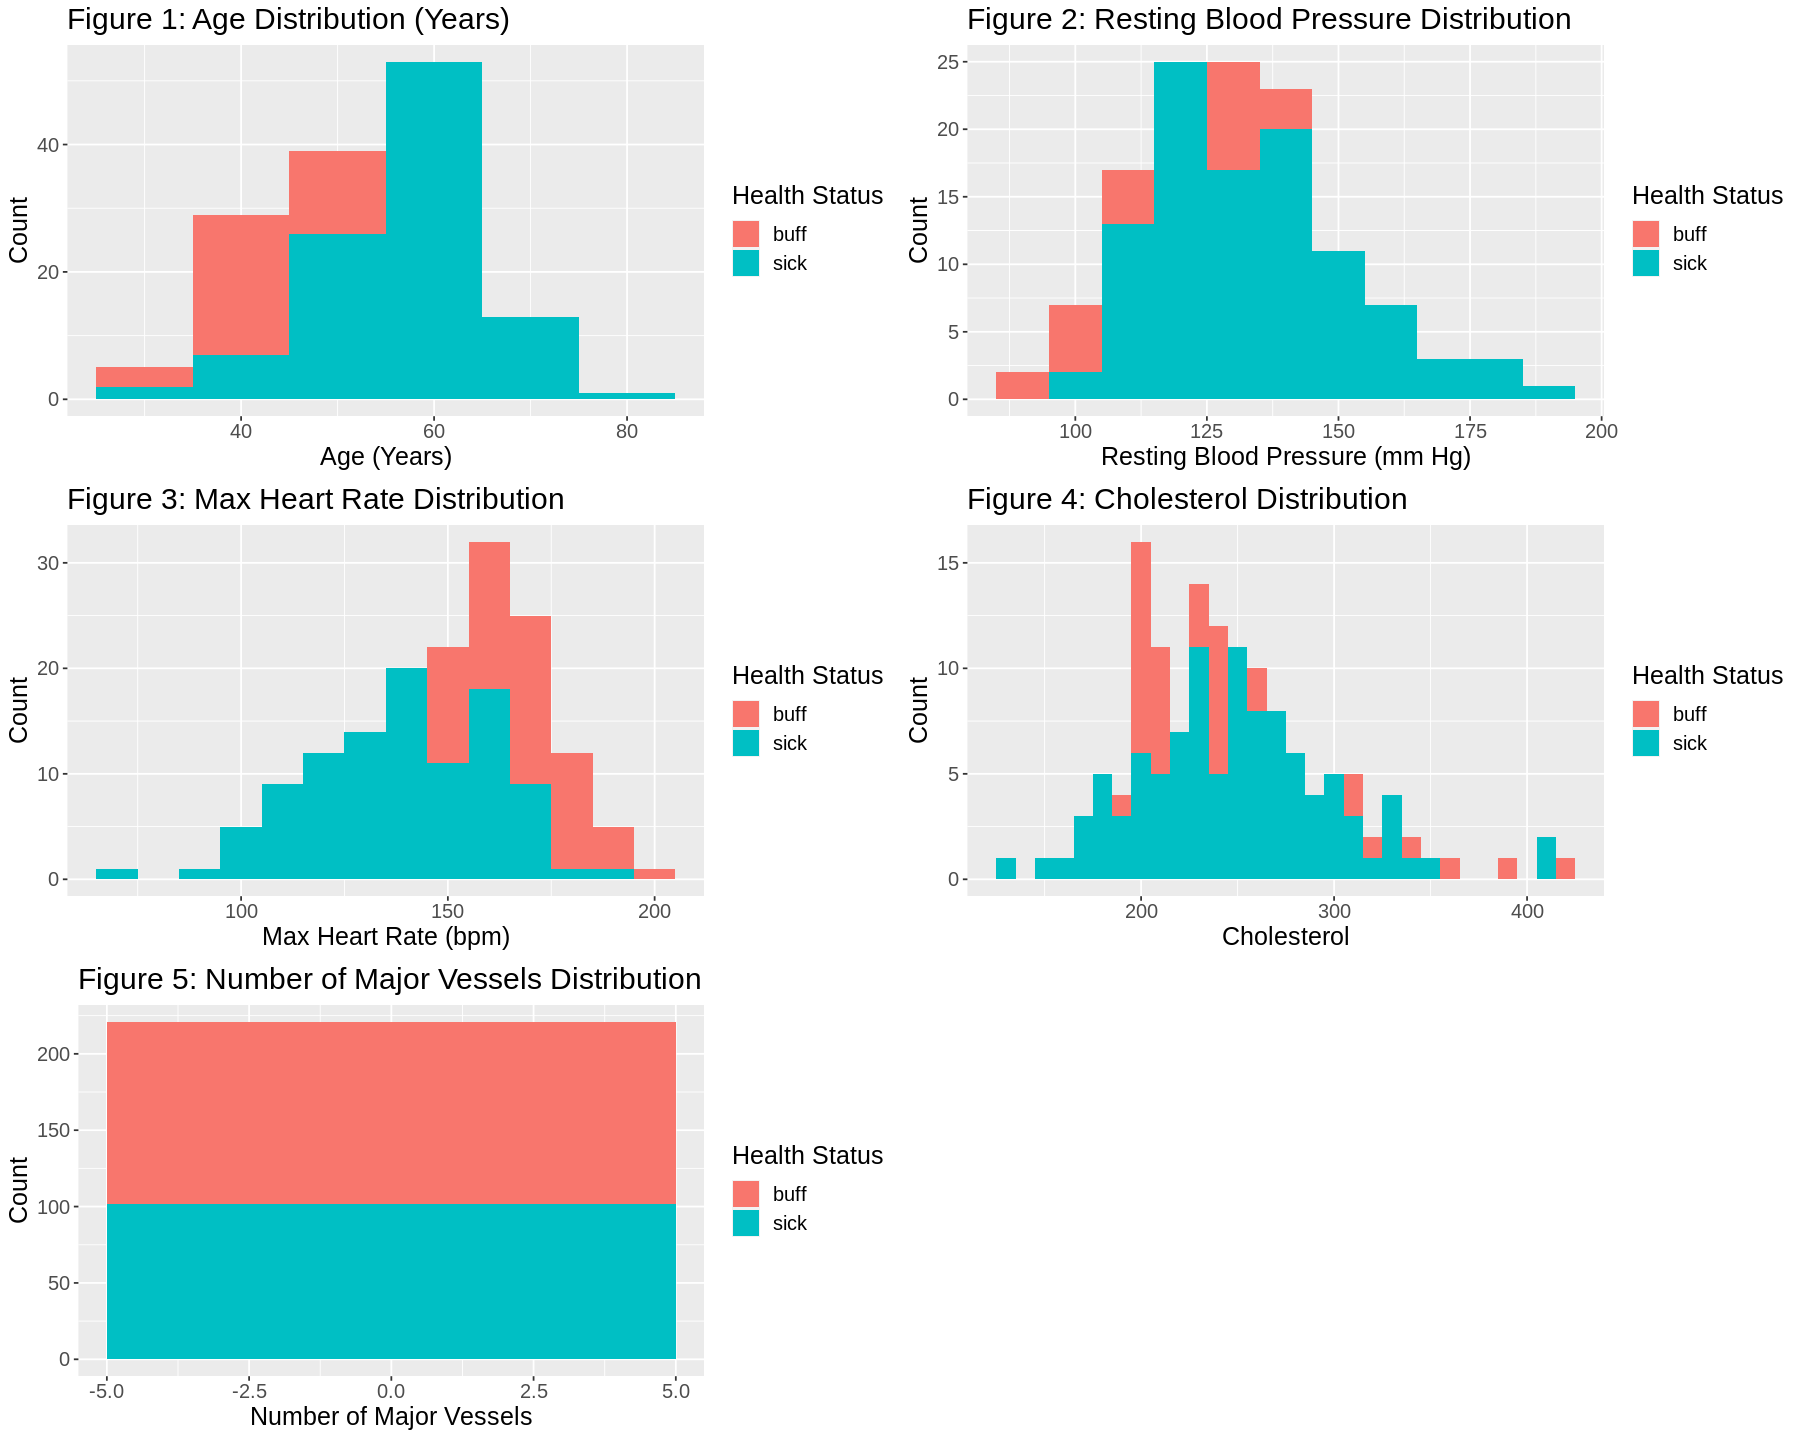

In [58]:
options(repr.plot.width = 15, repr.plot.height = 12)


#Visualizing the distribution of each predictor variable
plot_1 <- clev_train_clean %>%
    ggplot(aes(x=age, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Age (Years)", y="Count", fill="Health Status")+
    ggtitle("Figure 1: Age Distribution (Years)") +
    theme(text = element_text(size = 15)) 
  #to see the correlation between age and heart disease to see if age alone can be a strong predictor 

plot_2 <- clev_train_clean %>%
    ggplot(aes(x=rest_bp, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Resting Blood Pressure (mm Hg)", y="Count", fill="Health Status")+
    ggtitle("Figure 2: Resting Blood Pressure Distribution") +
    theme(text = element_text(size = 15)) 
 #to see the correlation between resting blood pressure and heart disease to see if resting blood pressure alone can be a strong predictor

plot_3 <- clev_train_clean %>%
    ggplot(aes(x=max_hr, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Max Heart Rate (bpm)", y="Count", fill="Health Status")+
    ggtitle("Figure 3: Max Heart Rate Distribution") +
    theme(text = element_text(size = 15)) 
 #to see the correlation between maximum heart rate and heart disease to see if maximum heart rate alone can be a strong predictor  

plot_4 <- clev_train_clean %>%
    ggplot(aes(x=chol, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Cholesterol", y="Count", fill="Health Status")+
    ggtitle("Figure 4: Cholesterol Distribution") +
    theme(text = element_text(size = 15)) 
  #to see the correlation between cholesterol levels and heart disease to see if cholesterol levels alone can be a strong predictor 

plot_5 <- clev_train_clean %>%
    ggplot(aes(x=num_bv, fill=class))+
    geom_histogram(binwidth = 10)+
    labs(x="Number of Major Vessels", y="Count", fill="Health Status")+
    ggtitle("Figure 5: Number of Major Vessels Distribution") +
    theme(text = element_text(size = 15)) 
 #to see the correlation between number of major blood vessels and heart disease to see if having a certain number of healthy blood

#Showing the distribution graphs side by side
    plot_grid(plot_1, plot_2, plot_3, plot_4, plot_5, ncol = 2)


Figure 1 shows the distribution of age within the population and is coloured according to whether the person has heart disease (blue) or not (red). As you can see, as age increases, people are more frequently recorded to have heart disease peaking around the age of 60 so that demonstrates that age contributes to whether a person is sick or not.  

Figure 2 shows the distribution of resting blood pressure within the population. There seems to be a slight increase in the frequency of heart disease when there is an increase in blood pressure, however it is difficult to tell from just this graph. 

Figure 3 shows the distribution of max heart rate within the population. As heart rate increases, the probability of having heart disease decreases. As well, the total population of those who are sick is skewed to the right compared to the total distribution so max heart rate could potentially be a good predictor of heart disease. 

Figure 4 shows the distribution of cholesterol levels within the population with the majority of people having heart disease. There seems to be a higher percentage of healthy people between the levels of 190-260, however it is difficult to tell from this graph whether this would be a good predictor or not.

Figure 5 shows the distribution of the number of major blood vessels within the population. The number of people with each number of major blood vessels is equal throughout, as well, the split between sick and healthy people is even so it is hard to tell whether this will be a good predictor or not without further analysis.


Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing non-finite values (stat_density).”


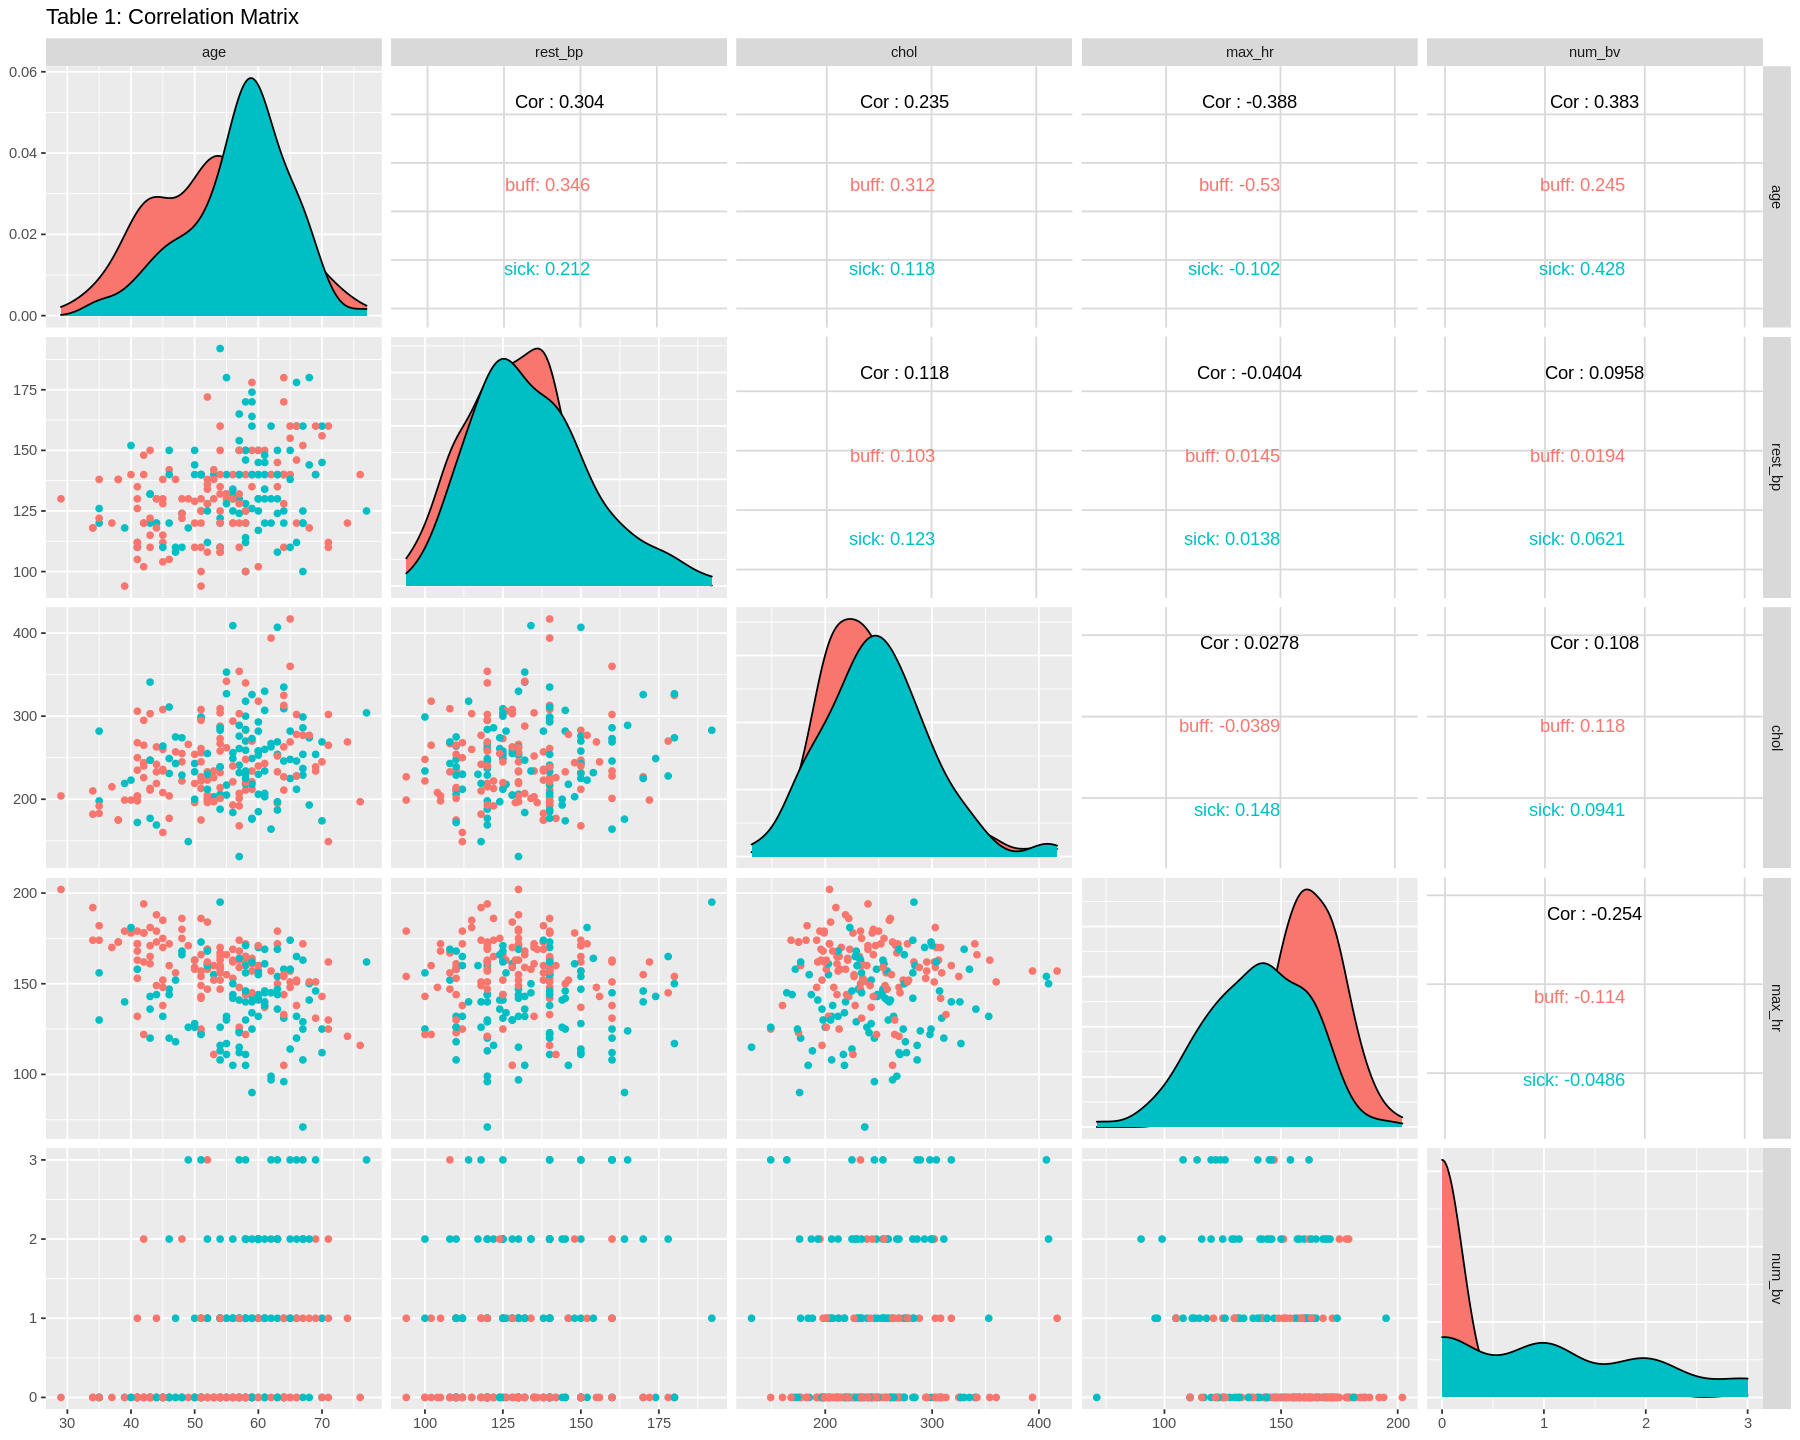

In [59]:
#Here, in order to explore the relationship between each variable further, 
#we will use the ggpairs function to visualize the correalation, and distribution of each attribute

#Visualizing the correlation between each variable
heart_pairs <- clev_train %>%
ggpairs(columns = 1:5, ggplot2::aes(colour = class), title = "Table 1: Correlation Matrix")
heart_pairs

##### Figure 6: Correlation Matrix for Each Attribute

Above is the correlation matrix with each of the five attributes we are analysing. To the right of the diagonal are the correlation coefficients between each variable for both sick and healthy people. Along the diagonal is the distribution graph of each variable, coloured for being sick (blue) or healthy (red). Finally, to the left of the diagonal is a scatterplot between each variable that is coloured for being sick or healthy. 

By looking at each variable, it is clear that age has a relatively high correlation with each variable, the same is true for cholesterol, number of major blood vessels and max heart rate. Furthermore, by looking at the distribution between each variable, you can see there is a distinct difference in distribution between the values of people who are sick and those who are healthy in age, max heart rate and number of blood vessels so these could potentially be good predictors.


In [60]:
#To further investigate which predictors to use, we will estimate the accuracy of 
#different combinations of predictors using forward selection

#First assigning all of the predictor names to an object
names <- colnames(clev_train_clean %>% select(-class))


# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(clev_train_clean, v = 5, strata = class)

# store the total number of predictors
n_total <- length(names)

# store selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = clev_train_clean) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(heart_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = heart_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold3: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold4: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold5: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold3: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold4: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold5: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ num_bv,0.7239840
2,class ~ num_bv+max_hr,0.7415457
3,class ~ num_bv+max_hr+age,0.7689382
4,class ~ num_bv+max_hr+age+rest_bp,0.7593235
5,class ~ num_bv+max_hr+age+rest_bp+chol,0.7231525


##### Table 3: Estimated Accuracies for Each Model String

By looking at the tibble above, you can see that by using the predictors 'number of major vessels', 'age', and 'max heart rate' create the most accurate model. This aligns with our predictions above using ggpairs and analysing the distribution. Therefore, we will use these three predictors when designing our classification model. 

## Methods:
We will do a classification to predict whether the individual has heart disease or not. The predictors we will be using are 'number of major blood vessels', 'maximum heart rate', and 'age'. According to the analysis we have done so far on the accuracies of each predictor, these have proven to be the best ones to use. Since we are predicting a factor variable, or a class, we are using k-nearest neighbors to do this classification. K-nearest neighbors calculates the Euclidean distance between nearby points and the new observation and then assigns the unknown the average class in the surrounding area. To find the optimal k-value, we will use cross validation on our training data to iteratively estimate the accuracy of different values of k. Then, we will choose the value of k with the highest accuracy and create our model with that value. Finally, we will compute the accuracy of our model by using our test data to validate it. From there we can determine whether our model is sufficient in this application.

## Data Analysis:

In [61]:
# Doing preprocessing and standardizing the predictors by passing the vector and the predictor variables to the recipe function.
clev_recipe <- recipe(class ~  age + max_hr + num_bv, data = clev_train_clean) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
clev_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [62]:
#Doing a 5-fold cross-validation. First step of finding the optimal K value that will be used.
clev_vfold <- vfold_cv(clev_train_clean, v = 5, strata = class)

In [63]:
#Creating a model specification with tuning on the number of neighbours.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [64]:
#Creating a data frame with neighbors variable containing values from 1 to 10.
k_range <- tibble(neighbors = seq(from = 1, to = 10))

#Creating a workflow analysis that combines the recipe and the model specification and that tunes 10 values for K.
vfold_metrics <- workflow() %>%
       add_recipe(clev_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples =clev_vfold, grid = k_range) %>%
       collect_metrics()
#Filtering for accuracy to find the best value of the number of neighbors. 
accuracy <- filter(vfold_metrics, .metric=="accuracy")
accuracy

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold3: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold4: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold5: internal: No observations were detected in `truth` for level(s): ' buff'...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6968029,5,0.02506959,Model01
2,accuracy,multiclass,0.6968029,5,0.02506959,Model02
3,accuracy,multiclass,0.7284332,5,0.01036589,Model03
4,accuracy,multiclass,0.7284332,5,0.01036589,Model04
5,accuracy,multiclass,0.7191261,5,0.01335710,Model05
6,accuracy,multiclass,0.7237773,5,0.00980176,Model06
7,accuracy,multiclass,0.7055955,5,0.01541582,Model07
8,accuracy,multiclass,0.7055955,5,0.01541582,Model08
9,accuracy,multiclass,0.7058022,5,0.01264620,Model09


##### Table 4: The Mean Accuracy for Each Value of K from 1-10

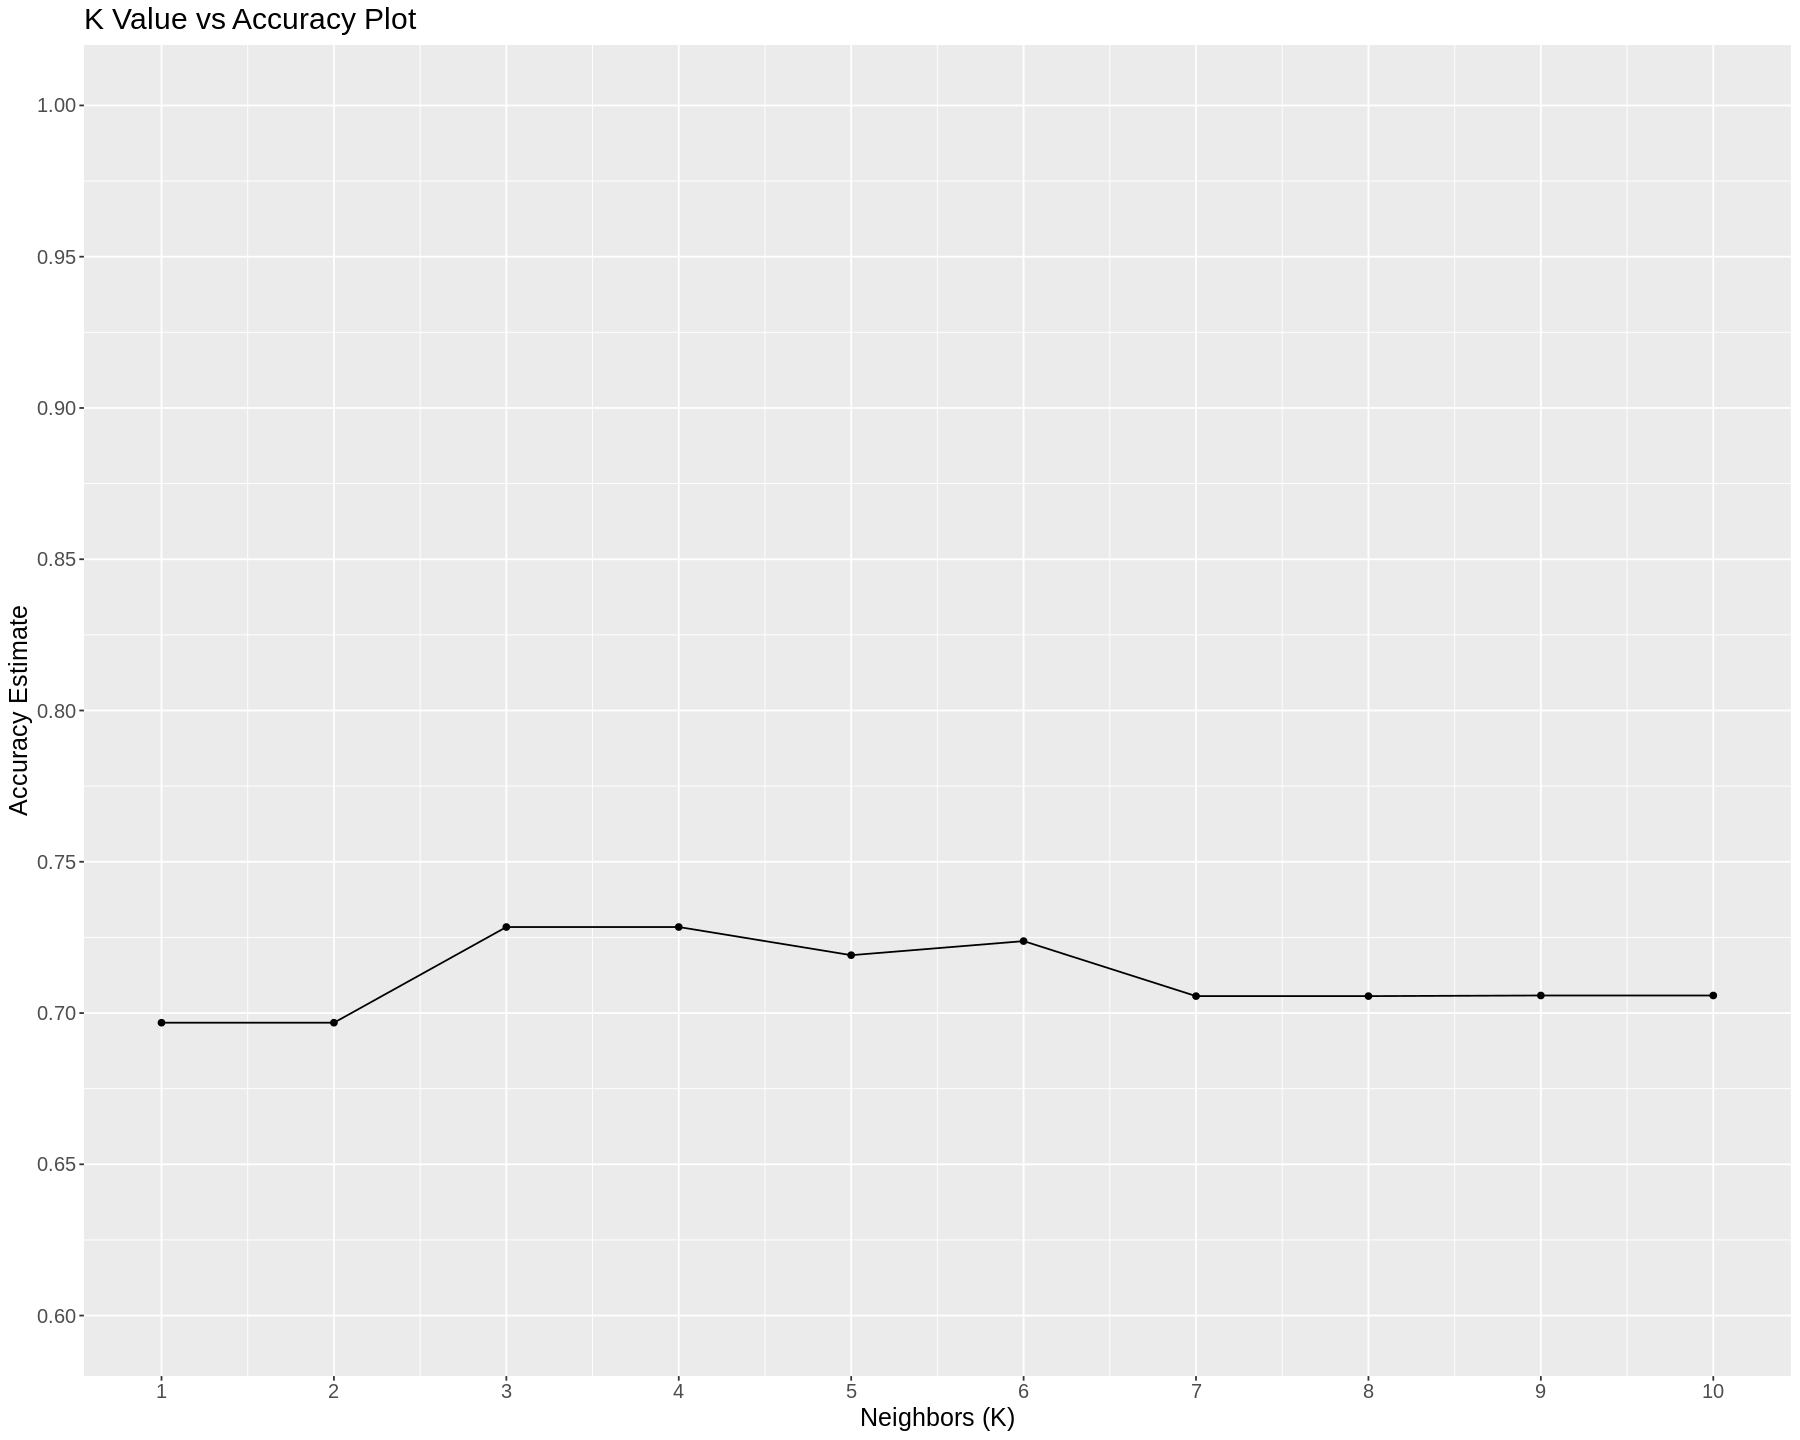

In [65]:
#Creating a K vs accuracy plot to find the best value of the number of neighbors.
cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
        geom_line()+
       labs(x = "Neighbors (K)", y = "Accuracy Estimate") +
        ggtitle("K Value vs Accuracy Plot") +
        theme(text = element_text(size = 15)) +
scale_x_continuous(breaks = seq(0, 24, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(breaks = seq(0.6, 1, by = 0.05), limits = c(0.6, 1.0)) # adjusting the y-axis
cross_val_plot

##### Figure 7: Plot of the Accuracy vs The Number of Neighbors (K)

In [66]:
#Pulling the K value that creates the highest accuracy.
k_val <- accuracy %>%
    arrange(mean)%>%
    slice(10)%>%
    pull(neighbors)
#Building the model, workflow analysis and fitting the model to trainin data with the best K value found above.
final_spec <- nearest_neighbor(weight_func= "rectangular", neighbors = k_val)%>%
    set_engine("kknn")%>%
    set_mode("classification")

final_workflow <-workflow()%>%
    add_recipe(clev_recipe)%>%
    add_model(final_spec)

final_fit <- final_workflow %>%
    fit(data=clev_train_clean)
final_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_val,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2850679
Best kernel: rectangular
Best k: 4

In [67]:
#Using the final model to predict on the test dataset and finding the accuracy of the model.
predictions <-predict(final_fit, clev_test_clean)%>%
bind_cols(clev_test_clean)

final_metrics <-predictions %>%
    metrics(truth=class, estimate=.pred_class)
final_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7333333
kap,multiclass,0.4646681


##### Table 5: The Accuracy of the Model using Testing Data

In [68]:
#Reporting the confusion matrix.
clev_conf_mat <-predictions %>%
    conf_mat(truth=class, estimate=.pred_class)
clev_conf_mat

          Truth
Prediction buff sick  buff  sick
     buff    30    9     0     0
     sick    11   25     0     0
      buff    0    0     0     0
      sick    0    0     0     0

##### Figure 8: Confusion Matrix Showing The Number of Observations Correctly or Falsely Predicted

## Discussion

We found that our model has an accuracy of 73.3% when using the predictors 'major blood vessels', 'maximum heart rate', and 'age'. Looking at our confusion matrix, we can see that it got 55 out of 75 of its predictions correct when using the testing data. Given how in our introduction to the data we discussed how heart disease is the leading cause of death from a non-transmissible source with 8.9 million people dying from it annually (Filate et al. 2003; Health Agency of Canada 2018), a 73.3% accuracy is not good enough to be used in practice. However, from our analysis when we looked at the distribution of individual predictors in Figures 1 through 5, we can see, for example, that there is an increase in heart disease at around 60 (Figure 1). We can also see that as heart rate increases so does the likelihood for heart disease (Figure 3). 

When beginning our analysis, we thought that the variables 'resting blood pressure' and 'cholesterol' would be good predictors of heart disease. After running some analysis on the accuracy of different variables however, we found that these would not be the best ones to use. We did not expect 'age', 'maximum heart rate', and 'major blood vessels' together to be our highest accuracy predictors. These predictors when assessing accuracy of different variable combinations showed a 76.9% accuracy. 'Age' and 'maximum heart rate' were predictors we thought from the beginning would be good predictors, as from our previous knowledge of heart disease we knew that a person gets it when they are older and have an abnormal heart rate. From the model we created, we expected to create one with a higher accuracy so it would be more viable in real life settings. Unfortunately, a model with a 73.3% accuracy is not good enough to be used when a person's life is on the line.

Although our model is not super accurate, we still have made some observations that can be useful. For example, in Figure 1 when we look at 'age' distribution we can see that there is a peak of sick individuals around the age of 60. This knowledge can be used by encouraging people to get checked for heart disease regularly beginning at around the age 50 and onward. Also, looking at Figure 3 on the distribution of 'maximum heart rate', we can see that there is a concentration of individuals with heart disease between the heart rate ranges of 190-260. This can be used as an indicator for an individual to get checked for heart disease if their heart rate falls between 190-260. Looking at these, we can say that our model can be used as a reference for when someone should seek a heart disease diagnosis, but not diagnose it itself. 

Future questions our analysis could lead to include what predictors could be used to increase our accuracy. With the variables we have in this data set, the best accuracy we could get is 73.3%, so what other variables could be recorded that would increase this accuracy? Or, is there some other combination of variables that would work better? Perhaps if we had more symptomatic variables, we could create a good predictor of when someone should get a diagnosis. For example, create a model that predicts based on noticeable symptoms to the individual that they can fill out online and find out if they should seek a diagnosis, similar to the Covid checklists of symptoms we have. 

Another potential application is researching ways to prevent heart disease, using the data we found above. After seeing the relationship between certain variables and heart disease, it could be useful to investigate what leads to these variables being within the range that is more likely for heart disease. For instance, what factors contribute to a rise in blood pressure, or what determines the number of major vessels you have. By investigating the contributors towards these attributes, doctors could possibly pre determine whether a patient is more likely to develop heart disease based on genetics or lifestyle habits. This could then lead to preventing heart disease from developing in the first place and therefore reduce the frequency in which it occurs creating an overall healthier population. 


## Sources

Filate, Woganee A., Helen L. Johansen, Courtney C. Kennedy, and Jack V. Tu. 2003. “Regional Variations in Cardiovascualr Mortality in Canada.” Canadian Journal of Cardiology 11 (19): 1241.

Government of Canada. 2017. “Heart Disease in Canada.” Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html.

Health Agency of Canada. 2018. “Report from the Canadian Chronic Disease Surveillance System: Heart Disease in Canada.” Canadian Electronic Library/desLibris. https://go.exlibris.link/CPyKsFFV.

Statista. 2021. “Death rate for major cardiovascular diseases in Canada from 2000 to 2019.” https://www.statista.com/statistics/434439/death-rate-for-major-cardiovascular-diseases-in-canada/.
